In [78]:
import pandas as pd
from sqlalchemy import create_engine,inspect,func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

In [79]:
# Read in both data tables to pandas
engine = create_engine("sqlite:///Data/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine,reflect = True)
Base.classes.keys()

['measurement', 'station']

In [48]:
Measurement = Base.classes.measurement
Station = Base.classes.station


AttributeError: 'Mapper' object has no attribute 'get_columns'

In [46]:
measurement_df = pd.read_sql("SELECT * FROM measurement",con = engine)
station_df = pd.read_sql("SELECT * FROM station",con = engine)

#Verify data import
display(measurement)
display(station)
display(measurement.count())

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


id         19550
station    19550
date       19550
prcp       18103
tobs       19550
dtype: int64

In [53]:
# Need to remove hardcoding here
# SELECT date FROM measurement ORDER BY column DESC LIMIT 1; Use this to select the last date
rainfall = pd.read_sql("""
SELECT date AS Date, prcp As Precipitation
FROM measurement 
WHERE Date > DATE('2016-08-23')
ORDER BY Date ASC;
                       """,con = engine)



,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


2223

<AxesSubplot:xlabel='Date'>

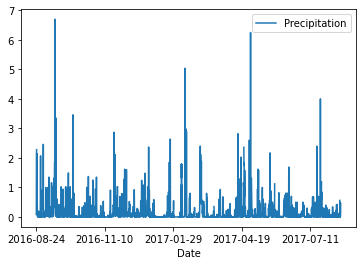

In [56]:
rainfall = rainfall.set_index("Date")
display(rainfall)
display(len(rainfall))
rainfall.plot()

In [57]:
rainfall.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [59]:
station_df["station"].count()

9

In [102]:
stationcounts = (measurement_df.groupby('station')
                 .agg({'prcp':'count','tobs':'count'})
                 .sort_values(by = "tobs",ascending = False)
                 .droplevel(0)
                )
display(stationcounts)

ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

In [100]:
stationcounts['tobs'].head(1)

station
USC00519281    2772
Name: tobs, dtype: int64

In [81]:
activestation_data = pd.read_sql("""
SELECT tobs AS Temperature
FROM  measurement
WHERE Date > DATE('2016-08-23') AND station = 'USC00519281'""", con = engine)
display(activestation_data)

,Temperature
0,79.0
1,80.0
2,79.0
3,77.0
4,78.0
...,...
2218,71.0
2219,78.0
2220,76.0
2221,76.0


<AxesSubplot:ylabel='Frequency'>

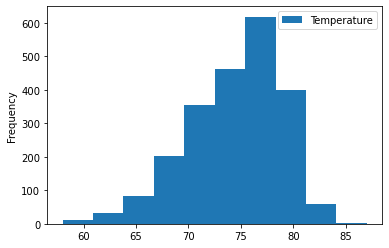

In [82]:
activestation_data.plot.hist(12)

# Climate App